# Import libraries

In [74]:
import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as VF

import torchvision
from torchvision import datasets, transforms

# Load MNIST datasets

## Add custom transform class to add Gaussian Noise

In [35]:
# Custom transform class to en-noise image data
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        noisy = tensor + torch.normal(mean=self.mean, std=self.std, size=tensor.size())
        noisy = torch.clamp(noisy, 0.0, 0.5)
        return (noisy, tensor)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

# Utility function to visualize image batches in grids
def show(imgs, title=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
    fig.suptitle(title)
    plt.show()

## Load MNIST datasets

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.8)
])

mnist_data = torchvision.datasets.MNIST(
    '/tmp/mnist', 
    download=True, 
    train=True, 
    transform=transform
)

loader = torch.utils.data.DataLoader(
    mnist_data,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

## Visualize noisy and normal samples

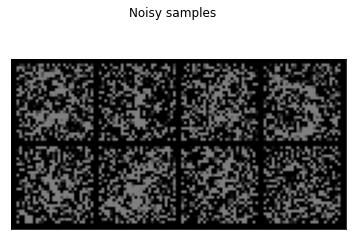

In [37]:
(images, normal), labels = next(iter(loader))
grid = torchvision.utils.make_grid(images, nrow=4, pad_value=0)
show(grid, title='Noisy samples')

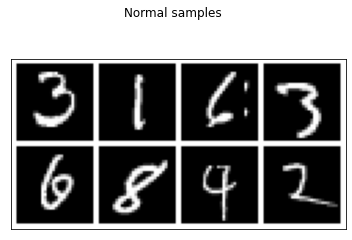

In [38]:
grid = torchvision.utils.make_grid(normal, nrow=4, pad_value=1)
show(grid, title='Normal samples')

# Define the network architecture

In [39]:
class ISTA_Module(nn.Module):
    def __init__(self, input_dim):
        super(ISTA_Module, self).__init__()
        self._lambda = nn.Parameter(data=torch.normal(size=(1,), std=1.0, mean=0.0))
        self.linear1 = nn.Linear(in_features=input_dim, out_features=input_dim)
        self.linear2 = nn.Linear(in_features=input_dim, out_features=input_dim)
        
    def soft_thresholding(self, x):
        return torch.sign(x) * F.relu(torch.abs(x) - self._lambda)
    
    def forward(self, x, y):
        outputs = self.soft_thresholding(self.linear1(x) + self.linear2(y))
        
        return outputs
    
class LISTA(nn.Module):
    def __init__(self, input_dim, L=10):
        super(LISTA, self).__init__()
        self.input_dim = input_dim
        self.L = L
    
        self.ista_modules = nn.ModuleList()
        
        for i in range(self.L):
            self.ista_modules.append(ISTA_Module(input_dim=self.input_dim))
        
    def forward(self, y):
        x = torch.zeros_like(y)
        
        for layer in self.ista_modules:
            x = layer(x, y)
            
        return x
    
class DenoiseNetwork(nn.Module):
    def __init__(self, input_dim, num_layers=3):
        super(DenoiseNetwork, self).__init__()
        self.num_layers = num_layers
        self.batchnorms = nn.ModuleList()
        self.layers = nn.ModuleList()
        
        for i in range(self.num_layers):
            self.layers.append(nn.Linear(in_features=input_dim, out_features=input_dim))
            self.layers.append(nn.BatchNorm1d(input_dim))
            
    def forward(self, x):
        outputs = x
        
        for norm, layer in zip(self.batchnorms, self.layers):
            x = layer(x)
            x = F.relu(x)
            x = norm(x)
            
        outputs = F.sigmoid(x)
        return outputs

In [40]:
(noisy, normal), labels = next(iter(loader))
noisy = torch.flatten(noisy, 1)
normal = torch.flatten(normal, 1)

input_dim = noisy.shape[1]

# Define training and visualization funtionalities

In [66]:
def get_device():
    '''
        Returns:
            - gpu : Whether GPU is available or not.
            - device : The device available on this machine.
    '''
    # Initialize device.
    device = torch.device('cpu')
    gpu = False
    
    if(torch.cuda.is_available()):
        device = torch.device('cuda')
        gpu = True
        print('[INFO] GPU is available ...')
    else:
        print('[INFO] GPU is not available ... ')
        
    return gpu, device

In [78]:
def train_lista(train_loader, head_layers=1, L=3, norm=1, lambda_=1e-4, lr=0.0001, epochs=10):
    '''
        Returns :
            - lista : Trained LISTA network for extracting sparse representation.
            - network : Head network used to perform pre-text tasks.
            
        Parameters : 
            - train_loader : Train data loader.
            - head_layers : Number of linear - relu - batchnorm modules in head network.
            - L : Number of ISTA modules in lista network.
            - norm : Order of the regularization term. 1 for L1, 2 for L2.
            - lambda_ : Regularizer coefficient.
            - lr : Learning rate.
            - epochs : Number of training iterations.
    '''
    norm_losses = []
    mse_losses = []
    
    gpu, device = get_device()
    lista = LISTA(input_dim, L=L).to(device)
    network = DenoiseNetwork(input_dim, num_layers=head_layers).to(device)

    optimizer1 = optim.Adam(lista.parameters(), lr=lr)
    optimizer2 = optim.Adam(network.parameters(), lr=lr)
    criterion = nn.MSELoss()
        
    try:
        for i in range(epochs):
            print(f'Epoch #[{i+1}/{epochs}]\n====================')
            time.sleep(1.0)
            
            with tqdm.tqdm(total=len(train_loader)) as pbar:
                for j, ((noisy, normal), labels) in enumerate(train_loader):  
                    optimizer1.zero_grad()
                    optimizer2.zero_grad()

                    noisy = torch.flatten(noisy, 1).to(device)
                    normal = torch.flatten(normal, 1).to(device)

                    x = lista(noisy)
                    reg = 0
                    if(norm is not None):
                        reg = lambda_ * torch.mean(torch.norm(x, p=norm, dim=1))
                    outputs = network(x)
                    mse = criterion(outputs, normal)
                    loss = mse + reg

                    norm_losses.append(reg)
                    mse_losses.append(mse)
                    loss.backward()

                    # Report epoch loss
                    pbar.set_postfix({
                        'MSE loss' : f'{mse.item():.4f}',
                        'L1 reg' : f'{reg:.4f}'
                    })
                    
                    optimizer1.step()
                    optimizer2.step()
                    
                    # Update progress bar
                    pbar.update(1)
                    
    except KeyboardInterrupt:
        print('[INFO] Training halted ... ')
        
    # Visualize loss
    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax2 = ax1.twinx()
    
    ax1.plot(list(range(1, len(mse_losses) + 1)), mse_losses, '-', label='MSE losses', color='blue')
    ax2.plot(list(range(1, len(norm_losses) + 1)), norm_losses, '-r', label=f'L{norm} losses', color='orange')
    
    ax1.set_ylabel('MSE Losses', color='blue')
    ax2.set_ylabel('L1 regularization', color='orange')
    ax1.set_xlabel('Epochs')
    
    fig.legend(loc='upper right')
    plt.title("Training Losses")
    plt.show()
    
    return lista, network

In [79]:
def visualize_result(loader, lista, network):
    '''
        Parrameters :
            - loader : Sample data loader.
            - lista : The sparse representation extractor network.
            - network : The head network.
    '''
    gpu, device = get_device()
    fig, ax = plt.subplots(4, 4, figsize=(16, 16))

    for i in range(4):
        (noisy, normal), labels = next(iter(loader))
        noisy = torch.flatten(noisy, 1).to(device)
        normal = torch.flatten(normal, 1).to(device)
        
        sparse_rep = lista(noisy)
        output = network(sparse_rep)
        output = output.reshape(8, 28, 28)
        if(not gpu):
            ax[i][0].imshow(noisy.detach().numpy().reshape(-1, 28, 28)[i], cmap='gray')
            ax[i][1].imshow(sparse_rep.detach().numpy().reshape(-1, 28, 28)[i], cmap='gray')
            ax[i][2].imshow(output.detach().numpy().reshape(-1, 28, 28)[i], cmap='gray')
            ax[i][3].imshow(normal.detach().numpy().reshape(-1, 28, 28)[i], cmap='gray')
        else:
            ax[i][0].imshow(noisy.cpu().detach().numpy().reshape(-1, 28, 28)[i], cmap='gray')
            ax[i][1].imshow(sparse_rep.cpu().detach().numpy().reshape(-1, 28, 28)[i], cmap='gray')
            ax[i][2].imshow(output.cpu().detach().numpy().reshape(-1, 28, 28)[i], cmap='gray')
            ax[i][3].imshow(normal.cpu().detach().numpy().reshape(-1, 28, 28)[i], cmap='gray')

        ax[i][0].set_title('Noisy image')
        ax[i][1].set_title('Sparse representation')
        ax[i][2].set_title('Predicted denoised image')
        ax[i][3].set_title('Ground truth')

    plt.show()

# Train sample networks and visualize results
## 1. Default settings
- Number of head layers : 1
- Number of ISTA modules : 3
- Regularization : L1
- Regularization coefficient : 1e-4

  0%|          | 0/7500 [00:00<?, ?it/s]

[INFO] GPU is available ...
Epoch #[1/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[2/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[3/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[4/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[5/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[6/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[7/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[8/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[9/10]


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch #[10/10]


100%|██████████| 7500/7500 [00:25<00:00, 288.59it/s, MSE loss=0.0730, L1 reg=0.0813]


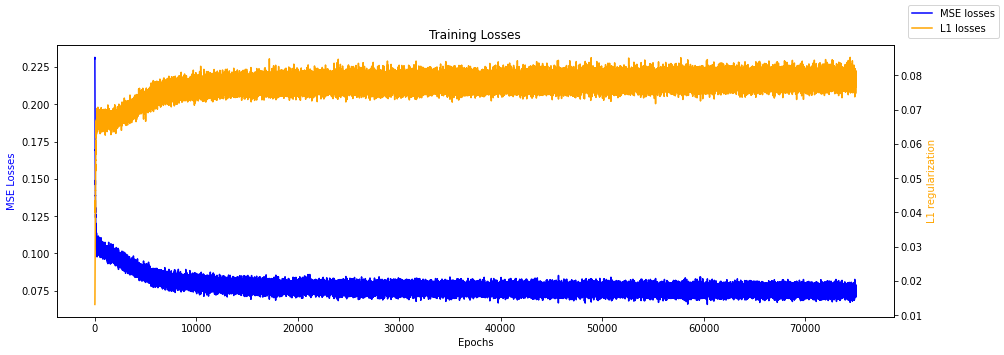

[INFO] GPU is available ...


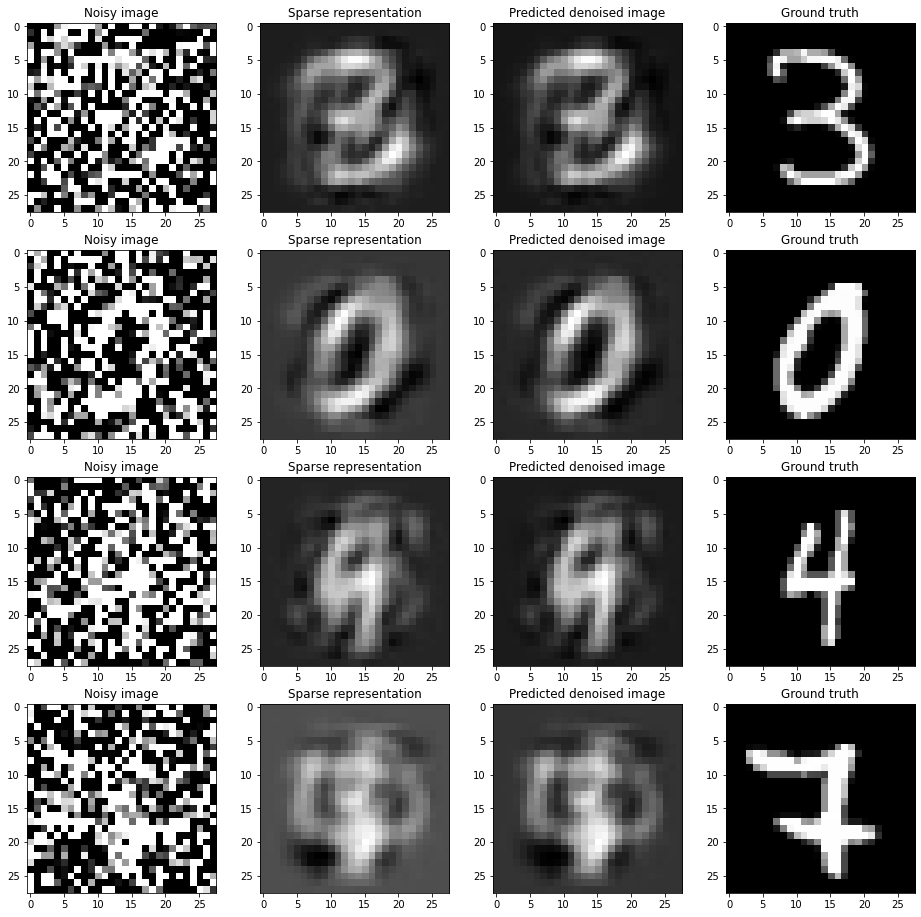

In [80]:
lista, network = train_lista(loader)
visualize_result(loader, lista, network)